In [31]:
# Import libraries and data
import pandas as pd

df = pd.read_csv("CSI500_data.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)


In [34]:
# Functions to calculate Technical indicators for mean reversiona and oversold
def calculate_rsi(data, window=14):
    close_delta = data.diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ema_up = up.ewm(com=window - 1, min_periods=window).mean()
    ema_down = down.ewm(com=window - 1, min_periods=window).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

def calculate_stochastic_oscillator(data, window=14):
    data_min = data.rolling(window=window).min()
    data_max = data.rolling(window=window).max()
    k = 100 * (data - data_min) / (data_max - data_min)
    d = k.rolling(window=3).mean()
    return k, d

def calculate_macd(data, fast_window=12, slow_window=26, signal_window=9):
    exp1 = data.ewm(span=fast_window, adjust=False).mean()
    exp2 = data.ewm(span=slow_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal


In [35]:
#Implementing technical Indicators
rsi_df = calculate_rsi(df)
upper_band_df, lower_band_df = calculate_bollinger_bands(df)
k_df, d_df = calculate_stochastic_oscillator(df)
macd_data , signal_data = calculate_macd(df)

In [36]:
# Filtering and Ranking of stocks based on Technical Indicators
filter_stocks = (rsi_df < 40 ) & (macd_data > signal_data)
filter_stocks = filter_stocks.astype(int)
filter_stocks['Stock_count'] = filter_stocks.sum(axis=1)
k_df_rank = k_df.rank(axis=1, ascending=True)

In [43]:
# Backtesting code
tradebook = pd.DataFrame(columns=['Datetime', 'Stock', 'Entry Price', 'Exit Price', 'Exit Time'])
close_df = df

for row in range(0, len(close_df)):
    date = close_df.index[row]
    time = close_df.index[row].time()

    if time == pd.to_datetime('9:30').time():
        # Select top 5 ranks from stochastic ranks that are part of filtered stocks each day
        selected_stocks = []
        for i in k_df_rank.iloc[row].sort_values().index:
            if filter_stocks[i][row] == 1:
                selected_stocks.append(i)
            if len(selected_stocks) == 5:
                break

        entry_price_l1 = {}
        for stock in selected_stocks:
            entry_price = close_df.loc[date, stock]
            entry_price_l1[stock] = entry_price
            tradebook = pd.concat([tradebook, pd.DataFrame({'Datetime': [date], 'Stock': [stock], 'Entry Price': [entry_price],'Exit Price': [0], 'Exit Time': [0] })], ignore_index=True)

    elif time > pd.to_datetime('9:30').time() and time < pd.to_datetime('14:57').time():
        # exit based on target and stoploss
        for stock in selected_stocks:
            entry_price = entry_price_l1[stock]
            current_price = close_df[stock][row]
            target = entry_price * 1.02  # Exit if price is above target
            stoploss = entry_price * 0.995  # Exit if price is below stoploss
            trade = tradebook.loc[(tradebook['Datetime'] ==  date.replace(hour=9, minute=30)) & (tradebook['Stock'] == stock)].index[0]

            if (current_price >= target) & (tradebook['Exit Price'][trade] == 0):
                tradebook['Exit Price'][trade] = target
                tradebook['Exit Time'][trade] = time

            elif (current_price <= stoploss) & (tradebook['Exit Price'][trade] == 0):
                tradebook['Exit Price'][trade] = stoploss
                tradebook['Exit Time'][trade] = time

    elif time == pd.to_datetime('14:57').time():
        # square off pending positions
        for stock in selected_stocks:
            entry_price = entry_price_l1[stock]
            current_price = close_df[stock][row]
            trade = tradebook.loc[(tradebook['Datetime'] ==  date.replace(hour=9, minute=30)) & (tradebook['Stock'] == stock)].index[0]

            if tradebook['Exit Price'][trade] == 0:
                tradebook['Exit Price'][trade] = current_price
                tradebook['Exit Time'][trade] = time

tradebook['PnL'] = (tradebook['Exit Price'] - tradebook['Entry Price'])/tradebook['Entry Price']

<ipython-input-43-27e1b7fdcce6>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook['Exit Price'][trade] = current_price
<ipython-input-43-27e1b7fdcce6>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook['Exit Time'][trade] = time
<ipython-input-43-27e1b7fdcce6>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook['Exit Price'][trade] = target
<ipython-input-43-27e1b7fdcce6>:35: SettingWithCopyWarning: 
A value 

In [2]:
import pandas as pd
#tradebook = pd.read_csv('Tradebook.csv')

In [44]:
tradebook['Datetime'] = pd.to_datetime(tradebook['Datetime'])

In [45]:
tradebook_insample = tradebook[tradebook['Datetime'] < pd.to_datetime('2022-06-30')]
tradebook_outsample = tradebook[tradebook['Datetime'] >= pd.to_datetime('2022-06-30')]

In [46]:
tradebook_insample['PnL'].sum()

0.46491673952768203

In [47]:
tradebook_outsample['PnL'].sum()

0.11301208188507668

In [48]:
(tradebook_insample['PnL'] > 0).sum()/len(tradebook_insample['PnL'] > 0) #Hit ratiio

0.3902439024390244

In [49]:
(tradebook_outsample['PnL'] > 0).sum()/len(tradebook_outsample['PnL'] > 0)

0.3442622950819672

In [50]:
dailypnl_outsample = tradebook_outsample.groupby('Datetime')['PnL'].sum().reset_index()
dailypnl_insample = tradebook_insample.groupby('Datetime')['PnL'].sum().reset_index()

In [51]:
#Eq weighted CSI 500 working
df = pd.read_csv("CSI500_data.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
eq_weighted_csi = pd.DataFrame(df.pct_change().drop(columns=['Unnamed: 0']).sum(axis = 1))
eq_weighted_csi['Date'] = eq_weighted_csi.index.date
eq_weighted_csi = eq_weighted_csi.groupby('Date')[0].sum().reset_index()
eq_weighted_csi = eq_weighted_csi[eq_weighted_csi['Date'] >= pd.to_datetime('2022-04-08')]
eq_weighted_csi[0] = eq_weighted_csi[0] /100

<ipython-input-51-f4f0874e14ea>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  eq_weighted_csi = eq_weighted_csi[eq_weighted_csi['Date'] >= pd.to_datetime('2022-04-08')]


In [53]:
dailypnl_insample.set_index('Datetime',inplace = True)
dailypnl_outsample.set_index('Datetime',inplace = True)


In [56]:
dailypnl_insample.index = dailypnl_insample.index.date
dailypnl_outsample.index = dailypnl_outsample.index.date

In [57]:
dailypnl_insample['Index_PnL'] = eq_weighted_csi.set_index('Date')[0]
dailypnl_outsample['Index_PnL'] = eq_weighted_csi.set_index('Date')[0]

In [59]:
dailypnl_outsample.sum()

PnL          0.113012
Index_PnL    0.009306
dtype: object

In [58]:
dailypnl_insample.sum()

PnL          0.464917
Index_PnL    0.300321
dtype: object

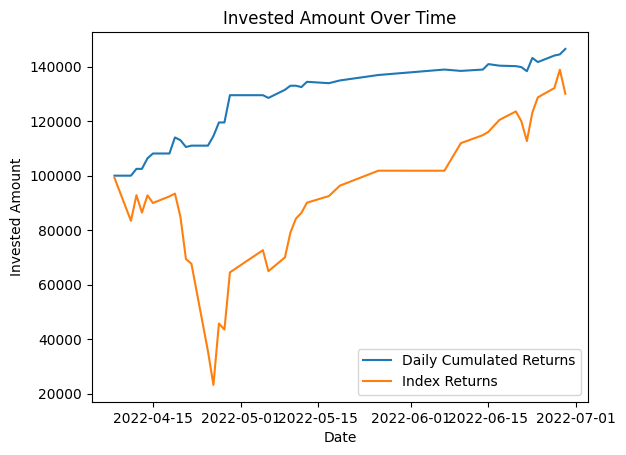

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pnl_df = dailypnl_insample

risk_free_rate = 0.05
market_returns = sum(pnl_df['Index_PnL'])
asset_returns = pnl_df['PnL']

notional = 100000

daily_returns = pnl_df['PnL'] * notional # Daily Returns
cumulative_returns = daily_returns.cumsum() # Cumulative Returns

sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns) # Calculate Sharpe Ratio
treynor_ratio = (np.mean(daily_returns) - risk_free_rate) / (market_returns* notional) # Calculate Treynor Ratio

# Plot the movement of the invested amount
plt.plot(pnl_df.index, cumulative_returns + notional,label='Daily Cumulated Returns')
plt.plot(pnl_df.index, (1+pnl_df['Index_PnL'].cumsum())*(notional),label='Index Returns')
plt.title('Invested Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Invested Amount')
plt.legend()
plt.show()

In [79]:
# Display the results
print("Sharpe Ratio:", sharpe_ratio)
print("Treynor Ratio:", treynor_ratio)

Sharpe Ratio: 0.5059488007169698
Treynor Ratio: 0.03969238342927872


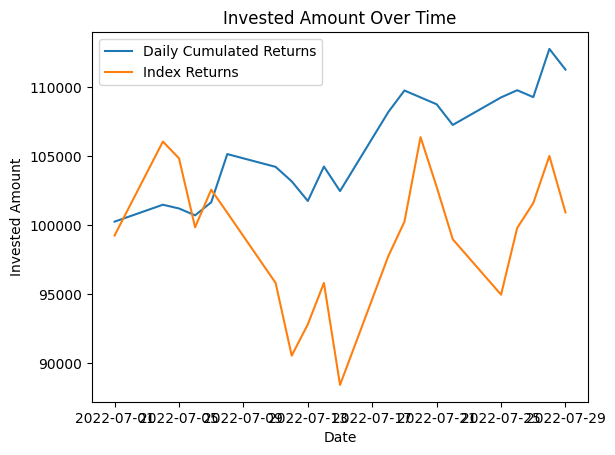

In [80]:
# Outsample Analysis

pnl_df = dailypnl_outsample

risk_free_rate = 0.05
market_returns = sum(pnl_df['Index_PnL'])
asset_returns = pnl_df['PnL']

notional = 100000

daily_returns = pnl_df['PnL'] * notional # Daily Returns
cumulative_returns = daily_returns.cumsum() # Cumulative Returns

sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns) # Calculate Sharpe Ratio
treynor_ratio = (np.mean(daily_returns) - risk_free_rate) / (market_returns* notional) # Calculate Treynor Ratio

# Plot the movement of the invested amount
plt.plot(pnl_df.index, cumulative_returns + notional,label='Daily Cumulated Returns')
plt.plot(pnl_df.index, (1+pnl_df['Index_PnL'].cumsum())*(notional),label='Index Returns')
plt.title('Invested Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Invested Amount')
plt.legend()
plt.show()

In [81]:
print("Sharpe Ratio:", sharpe_ratio)
print("Treynor Ratio:", treynor_ratio)

Sharpe Ratio: 0.27647319504664375
Treynor Ratio: 0.578260053364018


In [93]:
#Drawdown
cumulative_pnl = dailypnl_insample['PnL'].cumsum()
max_drawdown = (cumulative_pnl - cumulative_pnl.expanding().max()).min()
max_drawdown

In [103]:
# Brokerage
len(tradebook_insample)

123

In [120]:
123*0.0005

0.0615

In [113]:
#Slippage
tradebook_outsample['Entry Price Slipped'] = tradebook_outsample['Entry Price']*1.001
tradebook_insample['Entry Price Slipped'] = tradebook_insample['Entry Price']*1.001

<ipython-input-113-32e7c881b0b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook_outsample['Entry Price Slipped'] = tradebook_outsample['Entry Price']*1.001
<ipython-input-113-32e7c881b0b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook_insample['Entry Price Slipped'] = tradebook_insample['Entry Price']*1.001


In [116]:
#Slippage
tradebook_outsample['Slipped_PnL'] = (tradebook_outsample['Exit Price'] - tradebook_outsample['Entry Price Slipped'])/tradebook_outsample['Entry Price Slipped']
tradebook_insample['Slipped_PnL'] = (tradebook_insample['Exit Price'] - tradebook_insample['Entry Price Slipped'])/tradebook_insample['Entry Price Slipped']

<ipython-input-116-bf1d923814e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook_outsample['Slipped_PnL'] = (tradebook_outsample['Exit Price'] - tradebook_outsample['Entry Price Slipped'])/tradebook_outsample['Entry Price Slipped']
<ipython-input-116-bf1d923814e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradebook_insample['Slipped_PnL'] = (tradebook_insample['Exit Price'] - tradebook_insample['Entry Price Slipped'])/tradebook_insample['Entry Price Slipped']


In [117]:
sum(tradebook_outsample['Slipped_PnL'] )

0.05196012176332028

In [118]:
sum(tradebook_insample['Slipped_PnL'] )

0.34157516436333263